# 1. Install & Import Libraries (Colab Cell)

In [43]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, LSTM, GRU, Dense, Dropout,
    Layer, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 2. Load & Merge the Energy Consumption Data

In [44]:
# Load CSV files
paths = [
    "/content/KwhConsumptionBlower78_1.csv",
    "/content/KwhConsumptionBlower78_2.csv",
    "/content/KwhConsumptionBlower78_3.csv"
]

dfs = []
for p in paths:
    df = pd.read_csv(p)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# Drop unnecessary column
data.drop(columns=["Unnamed: 0"], inplace=True)

# Combine date and time into datetime
data["Datetime"] = pd.to_datetime(
    data["TxnDate"] + " " + data["TxnTime"]
)

data.sort_values("Datetime", inplace=True)
data.reset_index(drop=True, inplace=True)

data.head()

,TxnDate,TxnTime,Consumption,Datetime
0,01 Jan 2022,00:22:28,1.030,2022-01-01 00:22:28
1,01 Jan 2022,00:42:33,0.904,2022-01-01 00:42:33
2,01 Jan 2022,01:01:51,0.904,2022-01-01 01:01:51
3,01 Jan 2022,01:41:48,1.850,2022-01-01 01:41:48
4,01 Jan 2022,02:22:52,1.878,2022-01-01 02:22:52


# 3. Feature Engineering (Multivariate Transformation)

In [45]:
# Time-based features
data["hour"] = data["Datetime"].dt.hour
data["dayofweek"] = data["Datetime"].dt.dayofweek
data["month"] = data["Datetime"].dt.month

features = ["Consumption", "hour", "dayofweek", "month"]
data = data[features]

data.describe()

,Consumption,hour,dayofweek,month
count,3606.000000,3606.000000,3606.000000,3606.000000
mean,2.781508,11.442596,3.016362,1.484748
std,2.961248,6.912041,2.038331,0.499837
min,0.000000,0.000000,0.000000,1.000000
25%,0.948000,5.250000,1.000000,1.000000
50%,1.032000,11.000000,3.000000,1.000000
75%,4.005500,17.000000,5.000000,2.000000
max,27.284000,23.000000,6.000000,2.000000


# 4. Outlier Handling (IQR Clipping)

In [46]:
Q1 = data["Consumption"].quantile(0.25)
Q3 = data["Consumption"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

data["Consumption"] = data["Consumption"].clip(lower, upper)

# 5. Scaling (MinMaxScaler)

In [47]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaled_data.shape

(3606, 4)

# 6. Sequence Creation (Sliding Window)

In [48]:
def create_sequences(data, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, 0])  # Predict Consumption
    return np.array(X), np.array(y)

WINDOW_SIZE = 24

X, y = create_sequences(scaled_data, WINDOW_SIZE)

# Train / Test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, y_train.shape

((2865, 24, 4), (2865,))

# 7. Custom Bahdanau Attention Layer

In [49]:
class BahdanauAttention(Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, values, query):
        query = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# 8. Hybrid LSTM–GRU + Attention Model

In [50]:
inputs = Input(shape=(WINDOW_SIZE, X.shape[2]))

x = LSTM(64, return_sequences=True)(inputs)
x = GRU(32, return_sequences=True)(x)

query = GRU(32)(x)

attention = BahdanauAttention(32)
context_vector, attention_weights = attention(x, query)

concat = Concatenate()([context_vector, query])
output = Dense(1)(concat)

attention_model = Model(inputs, output)

attention_model.compile(
    optimizer=Adam(0.001),
    loss="mse"
)

attention_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 24, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 24, 64)    │     17,664 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 24, 32)    │      9,408 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 32)        │      6,336 │ gru_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention… │ [(None, 32),      │      2,145 │ gru_4[0][0],      │
│ (BahdanauAttention) │ (None, 24, 1)]    │            │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64)        │          0 │ bahdanau_attenti… │
│ (Concatenate)       │                   │            │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         65 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,618 (139.13 KB)

 Trainable params: 35,618 (139.13 KB)

 Non-trainable params: 0 (0.00 B)

# 9. Baseline LSTM Model

In [51]:
baseline = Sequential([
    LSTM(64, input_shape=(WINDOW_SIZE, X.shape[2])),
    Dense(1)
])

baseline.compile(
    optimizer=Adam(0.001),
    loss="mse"
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 10. Training (Best Practices)

In [52]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

history_attn = attention_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

history_base = baseline.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0836 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0304 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0257 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0215 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0216 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0203 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0170 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0192 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0187 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 10/50
81/81 

# 11. Evaluation Metrics

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_and_print(model, X_test, y_test, model_name):
    # Predict
    preds = model.predict(X_test, verbose=0).flatten()

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)

    # Avoid division by zero in MAPE
    epsilon = 1e-7
    mape = np.mean(np.abs((y_test - preds) / (y_test + epsilon))) * 100

    # Print formatted output
    print(f"{model_name} → RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}%")

    return rmse, mae, mape


# ===== Run Evaluation =====
attn_metrics = evaluate_and_print(
    attention_model, X_test, y_test, "Attention Model"
)

base_metrics = evaluate_and_print(
    baseline, X_test, y_test, "Baseline LSTM"
)

Attention Model → RMSE: 0.118 | MAE: 0.070 | MAPE: 236043.14%
Baseline LSTM → RMSE: 0.125 | MAE: 0.084 | MAPE: 210472.05%


# 12. Attention Weight Visualization (Interpretability)

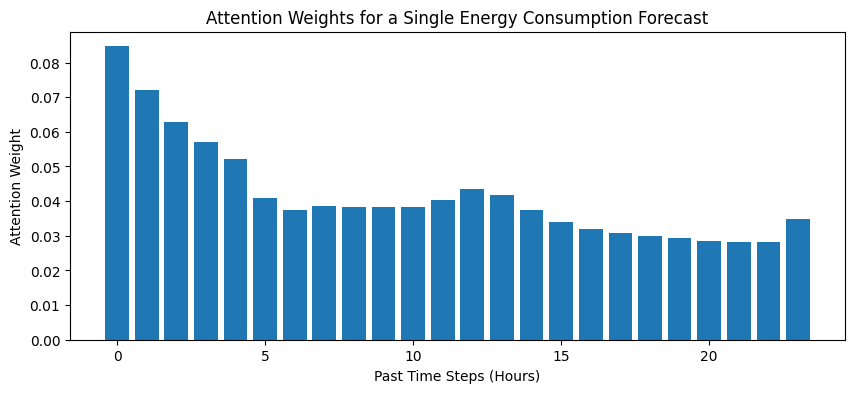

Attention weights shape: (24,)
Sum of attention weights: 1.0000001


In [54]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# -------------------------------
# Build a helper model to extract attention weights
# -------------------------------

# Locate the attention layer inside the trained model
attention_layer = None
for layer in attention_model.layers:
    if isinstance(layer, BahdanauAttention):
        attention_layer = layer
        break

assert attention_layer is not None, "Attention layer not found in model!"

# Create an intermediate model that outputs attention weights
attention_extractor = tf.keras.Model(
    inputs=attention_model.input,
    outputs=attention_layer.output[1]  # attention weights
)

# -------------------------------
# Select a test sample
# -------------------------------
sample_index = 0
sample_input = X_test[sample_index:sample_index+1]

# Extract attention weights
attention_weights = attention_extractor.predict(sample_input, verbose=0)

# Shape: (1, window_size, 1)
attention_weights = attention_weights.squeeze()

# -------------------------------
# Plot attention distribution
# -------------------------------
plt.figure(figsize=(10, 4))
plt.bar(range(len(attention_weights)), attention_weights)
plt.xlabel("Past Time Steps (Hours)")
plt.ylabel("Attention Weight")
plt.title("Attention Weights for a Single Energy Consumption Forecast")
plt.show()

print("Attention weights shape:", attention_weights.shape)
print("Sum of attention weights:", np.sum(attention_weights))